# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 5 ноября 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 5 ноября, -4 балла после 06:00 12 ноября, -6 баллов после 06:00 19 ноября  -8 баллов после 06:00 26 ноября.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 2] Фамилия Имя.<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1437]:
import warnings
warnings.filterwarnings("ignore")
%load_ext pycodestyle_magic

In [515]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import ceil

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь*** <br>
$$ w_{new} = w_{old} - \alpha \nabla_{w} L(w) = w_{old} + \frac{2\alpha}{n} 
\sum_{i=1}^{n} (y_i - w^T x_i)x_i^T -\frac{2\alpha}{C} w^T$$

Отдельно выпишем градиент функции потерь без регуляризации:
$$\nabla_{w} L(w) =  - \frac{2}{n} 
\sum_{i=1}^{n} (y_i - w^T x_i)x_i^T$$

Эту формулу можно переписать в векторном виде: 
$$\nabla_{w} L(w) =  - \frac{2}{n} \big[ X^T (\textbf{y} - X\textbf{w}) \big]^T $$


Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ...$$


Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь*** <br>

$$ \nabla_w L(w) = -\frac{1}{n} \sum_{i=1}^{n} \big[y_i \frac{\sigma'(w^T x)}{\sigma(w^T x)} x_i^T + 
(1-y_i) \frac{-\sigma'(w^T x)}{1 - \sigma(w^T x) } x_i^T 
\big] -\frac{2}{C} w^T  = 
-\frac{1}{n} \sum_{i=1}^{n} 
\big[y_i \frac{\sigma(w^T x)(1-\sigma(w^T x))}{\sigma(w^T x)} x_i^T + 
(1-y_i) \frac{-\sigma(w^T x)(1-\sigma(w^T x))}{1 - \sigma(w^T x) } x_i^T 
\big] -\frac{2}{C} w^T = 
-\frac{1}{n} \sum_{i=1}^{n} 
\big[y_i (1-\sigma(w^T x)) x_i^T + 
(y_i-1) \sigma(w^T x)) x_i^T 
\big] -\frac{2}{C} w^T = 
-\frac{1}{n} \sum_{i=1}^{n} 
\big[y_i (1-\sigma(w^T x)) x_i^T - 
(1-y_i) \sigma(w^T x) x_i^T 
\big] -\frac{2}{C} w^T -\frac{1}{n} \sum_{i=1}^{n} 
\big[y_i x_i^T - y_i \sigma(w^T x) x_i^T  - 
\sigma(w^T x)) x_i^T + y_i \sigma(w^T x) x_i^T
\big] -\frac{2}{C} w^T = 
-\frac{1}{n} \sum_{i=1}^{n} 
\big[y_i (1-\sigma(w^T x) x_i^T - 
(1-y_i) \sigma(w^T x) x_i^T 
\big] -\frac{2}{C} w^T = 
-\frac{1}{n} \sum_{i=1}^{n} 
\big[y_i x_i^T - \sigma(w^T x) x_i^T \big] -\frac{2}{C} w^T = 
-\frac{1}{n} \sum_{i=1}^{n} 
(y_i - \sigma(w^T x)) x_i^T +\frac{2}{C} w^T
$$
Отсюда,

$$ w_{new} = w_{old}  + \frac{\alpha}{n} \sum_{i=1}^{n} 
(y_i - \sigma(w^T x_i)) x_i^T - \frac{2\alpha}{C} w^T$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь*** <br>
Найдем гессиан функции потерь по весам, продифференцировав градиент:
$$
\frac{\partial^2{L}}{\partial w^2} = \frac{1}{\partial w} \big[ -\frac{2}{n}  X^T (\textbf{y} - X\textbf{w}) \big]^T = \frac{2}{n} \frac{1}{\partial w} \big[ X^T (X\textbf{w})\big]^T =
\frac{2}{n} \frac{1}{\partial w} \big[ (X\textbf{w})^T X \big] =
\frac{2}{n} \frac{1}{\partial w} \big[ \textbf{w}^T X^T X \big] = 
\frac{2}{n} X^T X
$$

Строгий минимум достигается лишь при положительно определенном гессиане т.е. при $X^T X > 0$

Решение с L2 регуляризацией будет иметь вид:
$$w = (\frac{1}{C} I + X^TX)^{-1}X^TY , $$
где $I$ - единичная матрица

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь*** <br>
Свободный член вводится в модель для того, чтобы уменьшить смещение модели - разницу между средним ответов модели и средним целевой переменной в обучающей выборке. Регуляризация же используется для того, чтобы сократить число рассмастриваемых решений и уменьшить переобучение - обычно мы штрафуем за большие веса т.е. способствуем тому, что модель выбирала решение ближе к нулю. Свободный член стоит вводить в регуляризацию, если мы заведомо знаем, в какой области должно располагаться наше решение. К примеру, если мы точно знаем, что решение будет состоять из положительных весов, нам стоит ввести отрицательный w0, чтобы штрафовать за отрицательные веса. 

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [154]:
X = np.random.randn(100, 5)
y = np.random.randint(0, 2, 100)

In [155]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y          - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    ind = np.arange(X.shape[0])
    np.random.shuffle(ind)
    
    xt = (batch_size - len(ind) % batch_size) % batch_size
    batches = [ind[batch_size*i : batch_size*(i+1)] for i in range(len(ind) // batch_size)]
    if xt:
        batches.append(np.hstack([ind[batch_size*(len(ind) // batch_size):], ind[:xt]]))
    
    for i in batches:
        X_batch = X[i]
        y_batch = y[i]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [1448]:
# %%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator,
                 C=1, alpha=0.01,
                 max_epoch=10,
                 model_type='lin_reg',
                 batch_size=10,
                 random_state=1,
                 clip_gradients=True):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        batch_size - размер батча при SGD
        random_state - seed для генератора случ. чисел
        clip_gradients - "обрезать" ли величину градиента
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : [],
                           'epoch' : [], 'epoch_loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        self.random_state = random_state
        self.clip_gradients = clip_gradients
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        if self.model_type == 'lin_reg':
            loss = np.mean(np.power((y_batch - np.dot(X_batch, self.weights) - self.b), 2))
        
        elif self.model_type == 'log_reg':
            x = sigmoid(np.dot(X_batch, self.weights) + self.b)
            loss = -np.mean(y_batch * np.log(x) + (1 - y_batch) * np.log(1-x))
        
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        if self.model_type == 'lin_reg':
            z = np.dot(X_batch, self.weights) + self.b
            m = y_batch - z
            loss_grad = -2*np.mean(X_batch * m.reshape(-1, 1), axis=0)
            loss_bgrad = -2*np.mean(m)
        
        elif self.model_type == 'log_reg':
            p = sigmoid(np.dot(X_batch, self.weights) + self.b)
            m = y_batch - p
            #loss_grad = -np.dot(X_batch.T, y_batch - p) / X_batch.shape[0]
            loss_grad = -np.mean(X_batch * m.reshape(-1, 1), axis=0)
            loss_bgrad = -np.mean(y_batch - p)
        
        return loss_grad, loss_bgrad
    
    def update_weights(self, new_grad, new_b_grad):
        if self.clip_gradients:
            self.weights -= np.clip(self.alpha*(new_grad + (2 / self.C)*self.weights), -1, 1)
            self.b -= np.clip(self.alpha*new_b_grad, -1, 1)
        else:
            self.weights -= self.alpha*(new_grad + (2 / self.C)*self.weights)
            self.b -= self.alpha*new_b_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        np.random.seed(self.random_state)
        self.weights = np.random.randn(X.shape[1])
        self.b = np.random.randn()
        n_batches = ceil(X.shape[0] / self.batch_size)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad, batch_bgrad = self.calc_loss_grad(X_batch, y_batch)
                
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
                self.update_weights(batch_grad, batch_bgrad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
            self.errors_log['epoch'].append(n)
            self.errors_log['epoch_loss'].append(
                np.mean(self.errors_log['loss'][n*n_batches:(n+1)*n_batches]))
                
        return self
    
    def predict(self, X, thr=0.5):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        thr - порог для предсказания класса 1
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        if self.model_type == 'lin_reg':
            y_hat = ((np.dot(X, self.weights) + self.b) >= 0).astype(np.int32)
        
        elif self.model_type == 'log_reg':
            y_hat = (sigmoid(np.dot(X, self.weights) + self.b) >= thr).astype(np.int32)
        
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [1356]:
def plot_decision_boundary(clf, color='red'):
    x = np.linspace(-10, 10, 1000)
    # для модели из sklearn
    if hasattr(clf, "coef_") and hasattr(clf, "intercept_"):
        y = -(clf.coef_.ravel()[0]*x + clf.intercept_)/ clf.coef_.ravel()[1]
    else:
        y = -(clf.weights[0]*x + clf.b)/ clf.weights[1]
    ind = np.where((-5 < y) & (y < 2))[0]
    x = x[ind]
    y = y[ind]
    plt.plot(x, y, c=color)

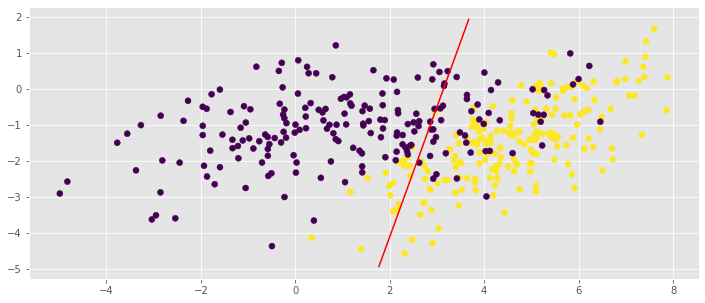

In [1435]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

your_model = MySGDClassifier(batch_generator, C=1, alpha=0.01, max_epoch=1000, model_type='log_reg')
your_model.fit(X,y)

plot_decision_boundary(your_model)

plt.scatter(X[:,0], X[:,1], c=y)

*Дополнительно* сравним с SGDClassifier из sklearn

In [1358]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

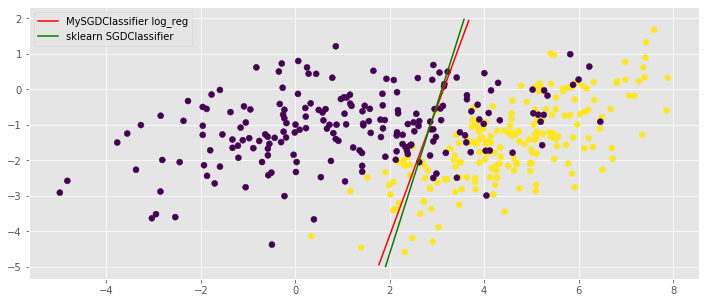

In [1436]:
np.random.seed(0)
sk_model = SGDClassifier(loss='log', warm_start=False, alpha=1, eta0=0.01, penalty='l2',
                         learning_rate='constant', validation_fraction=0.00001,
                         max_iter=1000)
sk_model.fit(X,y)
plot_decision_boundary(your_model, color='red')
plot_decision_boundary(sk_model, color='green')
plt.scatter(X[:,0], X[:,1], c=y)
plt.legend(('MySGDClassifier log_reg', 'sklearn SGDClassifier'))

Повторим то же самое и для линейной регрессии

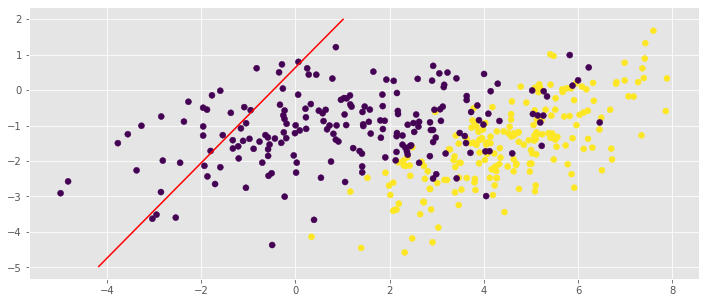

In [1433]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

your_model = MySGDClassifier(batch_generator,
                             C=1, alpha=0.01,
                             max_epoch=1000,
                             model_type='lin_reg')

your_model.fit(X,y)
plot_decision_boundary(your_model)
plt.scatter(X[:,0], X[:,1], c=y)

И линейная регрессия из sklearn'a

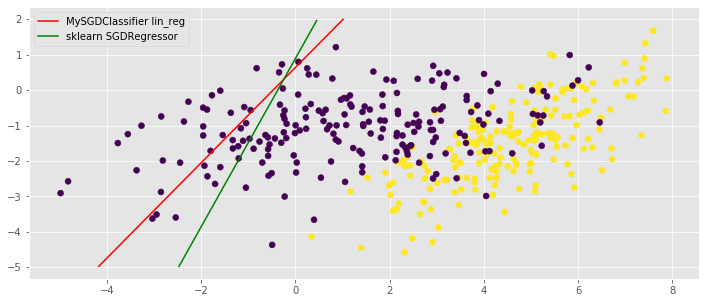

In [1434]:
np.random.seed(0)
sk_model = SGDRegressor(loss='squared_loss', warm_start=False,
                        alpha=1, eta0=0.01, penalty='l2',
                        learning_rate='constant',
                        validation_fraction=0.00001,
                        max_iter=1000)
sk_model.fit(X,y)
plot_decision_boundary(your_model, color='red')
plot_decision_boundary(sk_model, color='green')
plt.scatter(X[:,0], X[:,1], c=y)
plt.legend(('MySGDClassifier lin_reg', 'sklearn SGDRegressor'))

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [1190]:
from sklearn.datasets import make_classification

In [1191]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [1192]:
alphas = np.logspace(-5, -1, 5)

In [1193]:
%%time
log_alpha_res = []
lin_alpha_res = []
for a in alphas:
    log_model = MySGDClassifier(batch_generator,
                                C=1, alpha=a,
                                max_epoch=100,
                                model_type='log_reg',
                                batch_size=1000)
    lin_model = MySGDClassifier(batch_generator,
                                C=1, alpha=a,
                                max_epoch=100,
                                model_type='lin_reg',
                                batch_size=1000)

    log_model.fit(X,y)
    lin_model.fit(X,y)

    log_alpha_res.append(log_model)
    lin_alpha_res.append(lin_model)

CPU times: user 37.5 s, sys: 112 ms, total: 37.6 s
Wall time: 37.6 s


In [1221]:
def plot_loss_curves(models, N):
    alphas = []
    for model in models:
        alphas.append(model.alpha)
        loss_curve = model.errors_log['loss']
        # усредним по N
        loss_curve_means = [np.mean(loss_curve[i*N :(i + 1)*N])
                            for i in range(len(loss_curve) // N)]
        plt.plot(loss_curve_means)
    plt.title(f"{models[0].model_type}, N = {N}")
    plt.legend(alphas, title='alpha')  

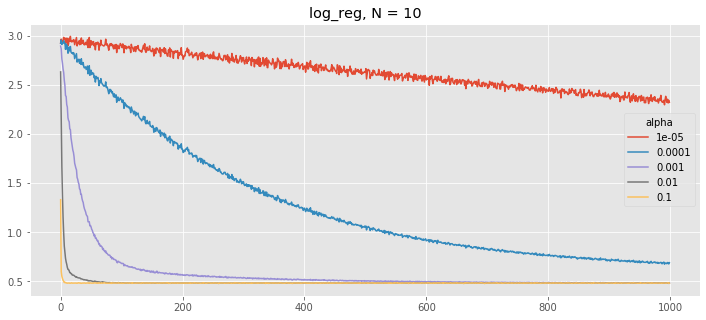

In [1224]:
plot_loss_curves(log_alpha_res, 10)

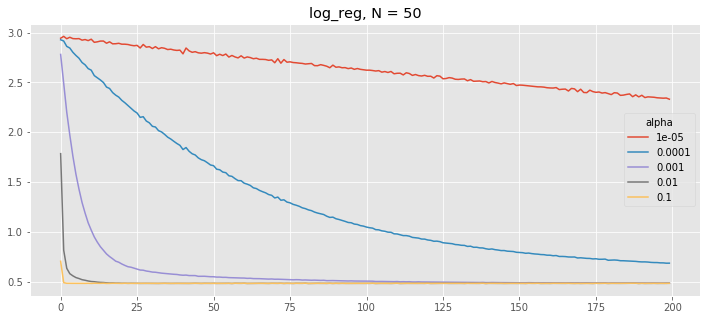

In [1225]:
plot_loss_curves(log_alpha_res, 50)

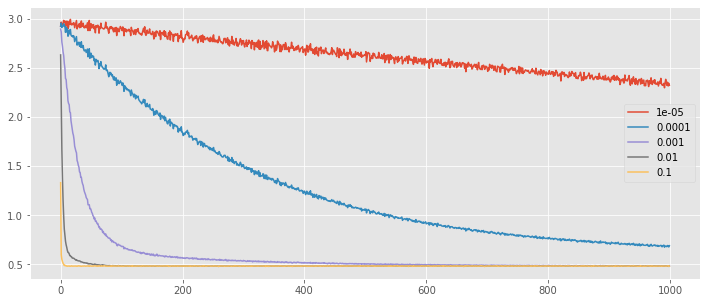

In [1208]:
N = 10
for model in log_alpha_res:
    loss_curve = model.errors_log['loss']
    # усредним по N
    loss_curve_means = [np.mean(loss_curve[i*N :(i + 1)*N])
                        for i in range(len(loss_curve) // N)]
    plt.plot(loss_curve_means)
plt.legend(alphas)

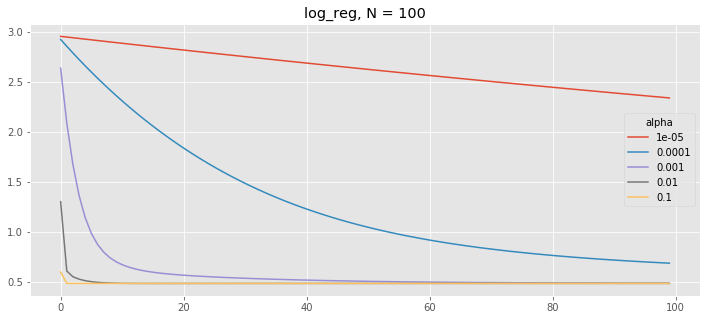

In [1226]:
plot_loss_curves(log_alpha_res, 100)

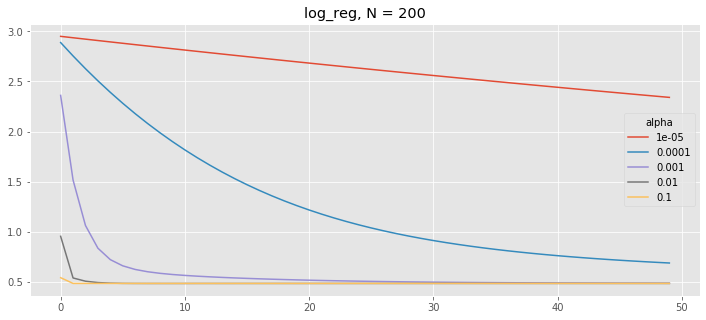

In [1227]:
plot_loss_curves(log_alpha_res, 200)

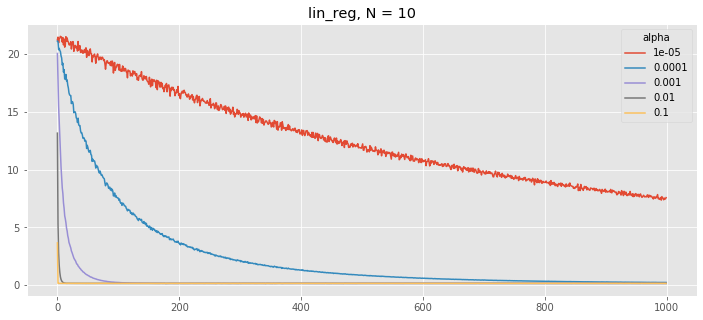

In [1228]:
plot_loss_curves(lin_alpha_res, 10)

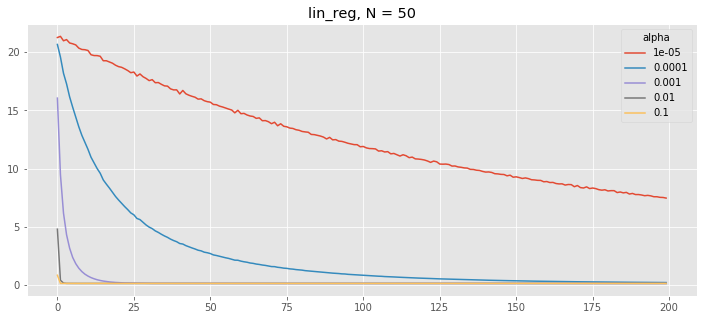

In [1229]:
plot_loss_curves(lin_alpha_res, 50)

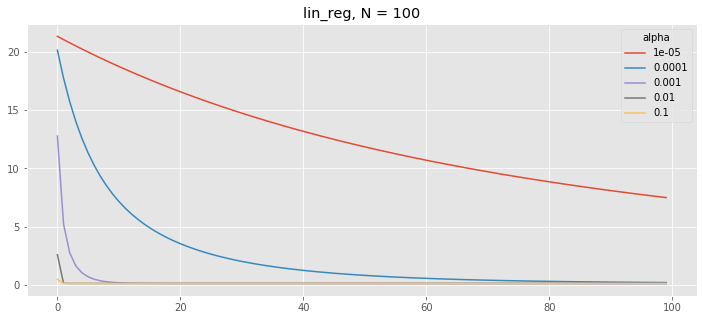

In [1230]:
plot_loss_curves(lin_alpha_res, 100)

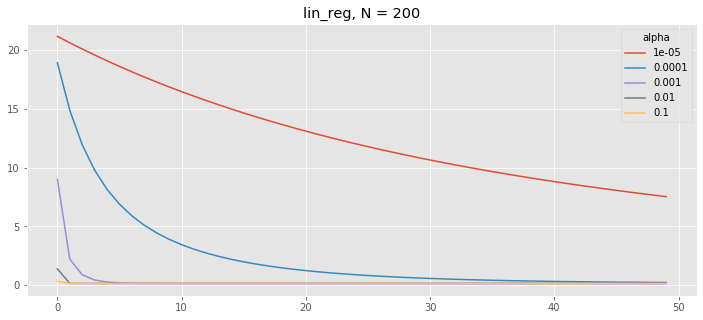

In [1231]:
plot_loss_curves(lin_alpha_res, 200)

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Чем выше темп обучения, тем быстрее сходимость. Однако, слишкая большая $\alpha$ может привести к тому, что мы не сможем попасть в локальный минимум - из-за большого градиентного шага мы будем постоянного "перепрыгивать" через минимум с одной стороны "расщелины" на другую

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [1338]:
Cs = np.logspace(3, -3, 10)

In [1419]:
%%time
log_C_res = []
lin_C_res = []
for C in Cs:
    log_model = MySGDClassifier(batch_generator,
                                C=C, alpha=0.0001,
                                max_epoch=100,
                                model_type='log_reg',
                                batch_size=100,
                                clip_gradients=False)

    lin_model = MySGDClassifier(batch_generator,
                                C=C, alpha=0.0001,
                                max_epoch=100,
                                model_type='lin_reg',
                                batch_size=100,
                                clip_gradients=False)

    log_model.fit(X,y)
    lin_model.fit(X,y)

    log_C_res.append(log_model)
    lin_C_res.append(lin_model)

CPU times: user 1.36 s, sys: 8 ms, total: 1.37 s
Wall time: 1.38 s


In [1428]:
def plot_mean_weights(models):
    Cs = []
    mean_weights = []
    for model in models:
        Cs.append(np.log10(model.C))
        mean_weights.append(model.weights.mean())

    plt.scatter(Cs, mean_weights)
    plt.title(f"{models[0].model_type}")
    plt.xlabel("log C")
    plt.ylabel("Среднее значение весов")

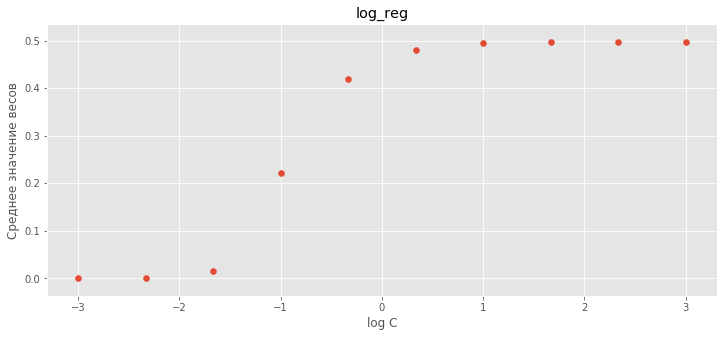

In [1429]:
plot_mean_weights(log_C_res)

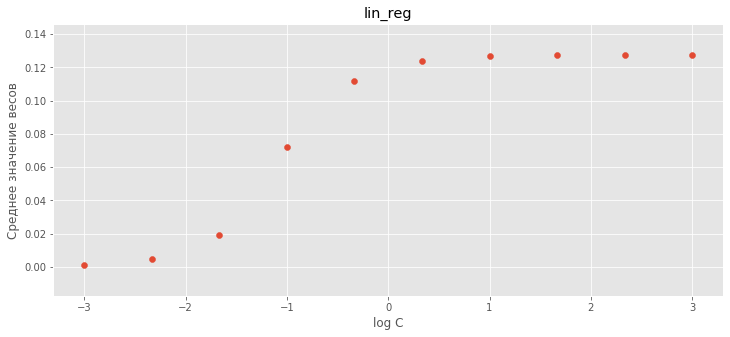

In [1430]:
plot_mean_weights(lin_C_res)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Да, при помощи регуляризации мы смогли довести среднее значение весов до ~0.

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [664]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))

28026


In [665]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [666]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split()) # уникальные слова заголовка
        for j in range(0, len(docs)): # обходим другие доки в той же категории
            if k == j: 
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j))) # находим число общих слов
        # в обучающую выборку добавляем 15 самых больших "расстояний"
        X_train.append(sorted(all_dist, reverse=True)[0:15]) 
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Повторим все те же операции над тестом

In [1132]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    #target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title, target))

In [1140]:
y_test = []
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_test.append(target_id)
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split()) # уникальные слова заголовка
        for j in range(0, len(docs)): # обходим другие доки в той же категории
            if k == j: 
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j))) # находим число общих слов
        # в обучающую выборку добавляем 15 самых больших "расстояний"
        X_test.append(sorted(all_dist, reverse=True)[0:15]) 
X_test = np.array(X_test)
y_test = np.array(y_test)
groups_test = np.array(groups_test)
print (X_test.shape, y_test.shape, groups_test.shape)

(16627, 15) (16627,) (16627,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [1002]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

In [1172]:
scaler = StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

Посмотрим, соблюдается ли баланс классов в нашей обучающей выборке

In [1174]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([8329, 3361]))

Объектов нулевого класса в 2.5 раза больше, чем объектов первого класса. Поэтому будем использовать кросс-валидацию со стратификацией.

In [1083]:
# разбиение на фолды 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

In [1175]:
# обозначим сетку параметров
param_grid = {'C': np.logspace(0, 3, 4), 
              'alpha': np.logspace(-5, -1, 5),
              'max_epoch': [100, 200, 500, 1000],
              'model_type': ['log_reg', 'lin_reg']
             }

In [1176]:
grid_search = GridSearchCV(estimator=MySGDClassifier(batch_generator,
                                                    batch_size=100,
                                                    model_type='log_reg'),
                          param_grid=param_grid,
                          n_jobs=12,
                          cv=folds,
                          scoring='accuracy',
                         )

In [1177]:
%%time
grid_search.fit(X_train, y=y_train)

CPU times: user 9.2 s, sys: 340 ms, total: 9.54 s
Wall time: 10min 17s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             error_score='raise-deprecating',
             estimator=MySGDClassifier(C=1, alpha=0.01,
                                       batch_generator=<function batch_generator at 0x7ff083816e18>,
                                       batch_size=100, max_epoch=10,
                                       model_type='log_reg', random_state=1),
             iid='warn', n_jobs=12,
             param_grid={'C': array([   1.,   10.,  100., 1000.]),
                         'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
                         'max_epoch': [100, 200, 500, 1000],
                         'model_type': ['log_reg', 'lin_reg']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [1178]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)

In [1179]:
grid_search_results.loc[(grid_search_results.rank_test_score == 1), 'params'].tolist()

[{'C': 100.0, 'alpha': 0.1, 'max_epoch': 100, 'model_type': 'log_reg'}]

In [1180]:
best_model = MySGDClassifier(batch_generator,
                             batch_size=100,
                             C=1000,
                             alpha=0.1,
                             max_epoch=100,
                             model_type='log_reg',
                            )

In [1181]:
best_model.fit(X_train, y_train)

MySGDClassifier(C=1000, alpha=0.1,
                batch_generator=<function batch_generator at 0x7ff083816e18>,
                batch_size=100, max_epoch=100, model_type='log_reg',
                random_state=1)

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [1182]:
def optimize_thr(X_train=X_train,
                 y_train=y_train,
                 stepsize=0.01,
                 model=MySGDClassifier(batch_generator,
                                       batch_size=100,
                                       model_type='log_reg'),
                 folds=KFold(n_splits=3, shuffle=True, random_state=1)
                ):
    
    thresholds = np.linspace(0, 1, ceil(1/stepsize)+1)
    folds_f1_scores = {'thr': thresholds}
    folds_f1_scores.update({k: [] for k in range(folds.n_splits)})

    for n, (tr_ind, val_ind) in enumerate(folds.split(X_train, y_train)):
        X_tr = X_train[tr_ind]
        y_tr = y_train[tr_ind]
        X_val = X_train[val_ind]
        y_val = y_train[val_ind]
        model.fit(X_tr, y_tr)

        for thr in thresholds:
            y_pred = model.predict(X_val, thr=thr)
            folds_f1_scores[n].append(f1_score(y_val, y_pred))

    res_df = pd.DataFrame(folds_f1_scores, index=thresholds)
    res_df['mean_F1'] = res_df[[0,1,2]].mean(axis=1)

    best_thr = res_df.loc[res_df['mean_F1'].argmax(), 'thr']
    best_f1_score = res_df['mean_F1'].max()

    return best_thr, best_f1_score

In [1183]:
best_thr, best_f1_score = optimize_thr(model=best_model, folds=folds)

In [1184]:
best_thr, best_f1_score

(0.28, 0.6188440453215067)

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

In [1185]:
test_pred = best_model.predict(X_test, thr=best_thr)

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук прислать Ваш ник на kaggle, под которым Вы залили решение, которое побило первый бейзлайн. **

In [1187]:
submit = pd.read_csv('sample_submission.csv')

In [1188]:
submit['target'] = test_pred

In [1189]:
submit.to_csv('submit1.csv', index=False)

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***